# pyMMF vs FDTD simulations (Comsol) for GRIN

For a parabolic graded index fiber, we compare here the results of pyMMF with the solvers `radial`, `eig`, and `WKB` 
with FDTD simulations using COMSOL.

In [1]:
import os, sys
sys.path.insert(0, os.path.abspath('../..'))


In [2]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import scipy

import sys
import pyMMF


SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rcParams.update({'font.size': MEDIUM_SIZE})
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
pyMMF.__file__

'/home/spopoff/dev/pyMMF/pyMMF/__init__.py'

## 1. Parameters of the fiber
Comsol simulation were done using those same parameters

In [3]:
NA = 0.2
radius = 25 # in microns
areaSize = 2.4*radius # calculate the field on an area larger than the diameter of the fiber
npoints = 2**7 # resolution of the window
n1 = 1.45
wl = 1.55 # wavelength in microns
curvature = None
k0 = 2.*np.pi/wl

r_max = 3.2*radius
npoints_search = 2**8
dh = 2*radius/npoints_search

## 2. Compute transverse modes using pyMMF's axisymmetric solver

In [4]:
profile = pyMMF.IndexProfile(npoints = npoints, areaSize = areaSize)
profile.initParabolicGRIN(n1=n1,a=radius,NA=NA)

********************************************************************************
<function IndexProfile.initParabolicGRIN.<locals>.radialFunc at 0x75db60340cc0>
<function IndexProfile.initParabolicGRIN.<locals>.radialFunc at 0x75db60340cc0>


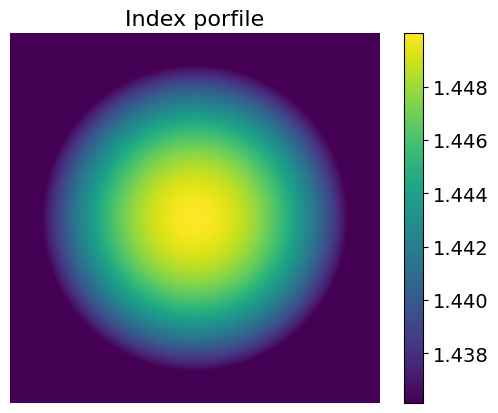

In [5]:
plt.figure()
plt.imshow(profile.n.reshape([npoints]*2))
plt.title(r'Index porfile')
plt.axis('off')
plt.colorbar()

In [6]:
solver = pyMMF.propagationModeSolver()
solver.setIndexProfile(profile)
solver.setWL(wl)

solver_options = {
    'r_max': r_max,     # max radius to calculate (and first try for large radial boundary condition)
    'dh' : dh,          # radial resolution during the computation     
    'N_beta_coarse' : 1_000,    # number of steps of the initial coarse scan
}

modes = solver.solve(
        solver='radial',
        curvature = None,
        options = solver_options
        )

2024-09-12 18:02:03,078 - pyMMF.core [DEBUG  ]  Debug mode ON.
2024-09-12 18:02:03,079 - pyMMF.solv [INFO   ]  Searching for modes with beta_min=5.821637357564584, beta_max=5.877818513168
2024-09-12 18:02:03,092 - pyMMF.solv [INFO   ]  Found 5 radial mode(s) for m=0
2024-09-12 18:02:03,093 - pyMMF.solv [INFO   ]  Searching propagation constant for |l| = 1
2024-09-12 18:02:03,095 - pyMMF.solv [ERROR  ]  Field limit 1.0 at the founded beta=0.05066217542815342 is greater than field_limit_tol=0.001
2024-09-12 18:02:03,095 - pyMMF.solv [WARNING]  Boundary condition could not be met.
2024-09-12 18:02:03,095 - pyMMF.solv [WARNING]  Retrying by changing r_max to 2.88a
2024-09-12 18:02:03,096 - pyMMF.solv [ERROR  ]  Field limit 1.0 at the founded beta=0.05066217542815342 is greater than field_limit_tol=0.001
2024-09-12 18:02:03,097 - pyMMF.solv [WARNING]  Boundary condition could not be met.
2024-09-12 18:02:03,097 - pyMMF.solv [WARNING]  Retrying by changing r_max to 2.59a
2024-09-12 18:02:03,

### Get the mode matrix and rearrange to mode order 
(to fit with comsol data later on)

In [7]:
M0_rad = modes.getModeMatrix(npola = 2)
Nmodes = modes.number
new_ind = [i//2 if i%2 == 0 else (i-1)//2+Nmodes for i in range(2*Nmodes)]
M0_rad = M0_rad[:,new_ind]
betas_as = np.sort(np.concatenate([modes.betas]*2))[::-1]
M = modes.m
L = modes.l

## 3. Compute transverse modes using pyMMF's 2D finite difference eigenvalue solver
See wavefrontshapin.net tutorial on [solving the Helmholtz discretized equation](https://www.wavefrontshaping.net/post/id/3) and on [pyMMF implementation](https://www.wavefrontshaping.net/post/id/6).

In [8]:
modes = solver.solve(
        solver='eig',
        options = {'nmodesMax' : Nmodes}
        )

2024-09-12 18:02:03,444 - pyMMF.solv [INFO   ]  Solving the spatial eigenvalue problem for mode finding.
2024-09-12 18:02:03,445 - pyMMF.solv [INFO   ]  Use close boundary condition.
2024-09-12 18:02:13,013 - pyMMF.solv [INFO   ]  Solver found 55 modes is 9.57 seconds.
2024-09-12 18:02:13,014 - pyMMF.solv [WARNING]  The solver reached the maximum number of modes set.
2024-09-12 18:02:13,015 - pyMMF.solv [WARNING]  Some propagating modes may be missing.
2024-09-12 18:02:13,016 - pyMMF.core [DEBUG  ]  Mode data stored in memory.


In [9]:
M0_eig = modes.getModeMatrix(npola = 2)
M0_eig = M0_eig[:,new_ind]
# dupliate the propagation constants for the two polarizations
betas_eig = np.abs(np.sort(np.concatenate([modes.betas]*2))[::-1])

## 4. WKB approximation

In [10]:
b = radius*n1/NA
f_parabolic = lambda r: np.sqrt(n1**2*(1.-(r/b)**2))

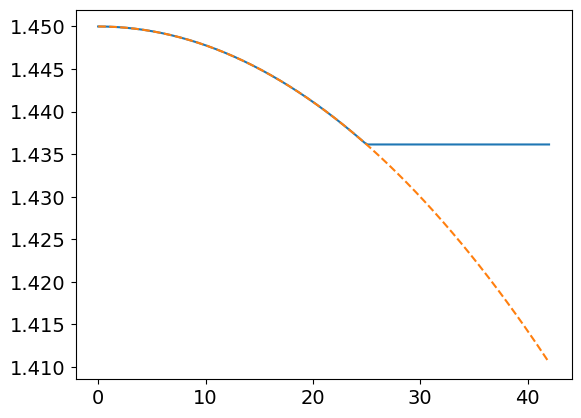

In [11]:
r_vec = np.linspace(0, 0.7*areaSize, 150)
real_profile = [profile.radialFunc(r) for r in r_vec]
infinite_GRIN_profile = [f_parabolic(r) for r in r_vec]
plt.figure()
plt.plot(r_vec,real_profile)
plt.plot(r_vec,infinite_GRIN_profile, '--')

## propagation constants under WKB approximation

$\beta_{l,m} = \sqrt{k_o^2 n_1^2-2\alpha \left( |l|+2m+1\right)}$

$\alpha = k_o n_1/b$ 

and 

$b = \frac{radius \times n_1}{NA}$

### Mode profile under WKB approximation

$\psi_{l,m}(r, \phi) = A e^{- \frac{\alpha r^2}{2}}
(\alpha r^2)^{|m|/2} L_l^{|m|}(\alpha r^2)e^{im\phi}
$

$L_l^{|m|}$ Laguerre polynomial

2024-09-12 18:18:26,635 - pyMMF.solv [INFO   ]  Finding analytical LP mode profiles associated to the propagation constants.
2024-09-12 18:18:26,635 - pyMMF.solv [INFO   ]  modes = 55
2024-09-12 18:18:26,672 - pyMMF.solv [INFO   ]  Found 55 LP mode profiles in 0.0 minutes.
2024-09-12 18:18:26,673 - pyMMF.core [DEBUG  ]  Mode data stored in memory.


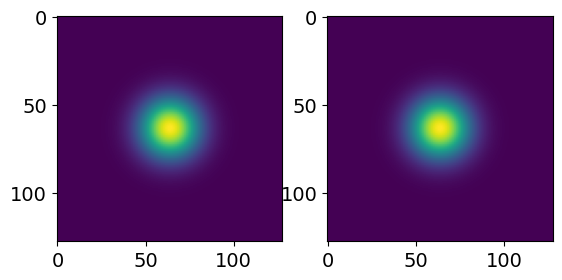

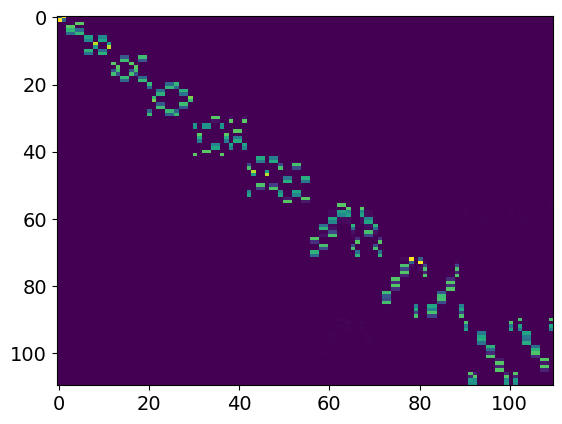

In [137]:
modes = solver.solve(
        solver='WKB',
        options = {'degenerate_mode' : "sin"}
        )
M0_wkb = modes.getModeMatrix(npola = 2)
betas_wkb = np.concatenate([modes.betas]*2)
new_ind = np.argsort(betas_wkb)[::-1]
betas_wkb = betas_wkb[new_ind]
M0_wkb = M0_wkb[:,new_ind]

## 5. Load Comsol data
We used the same paramters as for pyMMF calculations.
Simulation are full vectorial FDTD simulation, so we do have a 
(small) longitudinal component of the optical field. 

In [140]:
data = np.load('data/modes_transverse_comsol_128.npz')
# matrix of transverse mode profiles
M0_cs = data['M0_cs']
# propagation constats 
betas_cs = data['betas']

### Show one mode

Text(0.5, 0.98, 'Full vectorial FDTD (Comsol)\n Mode 45')

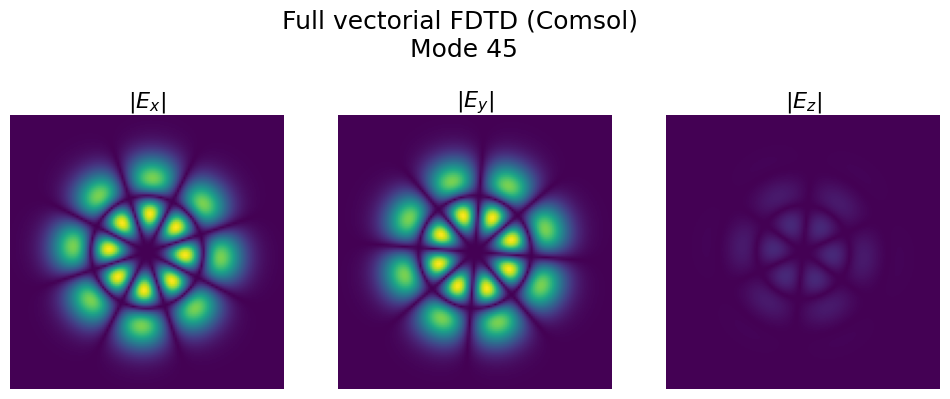

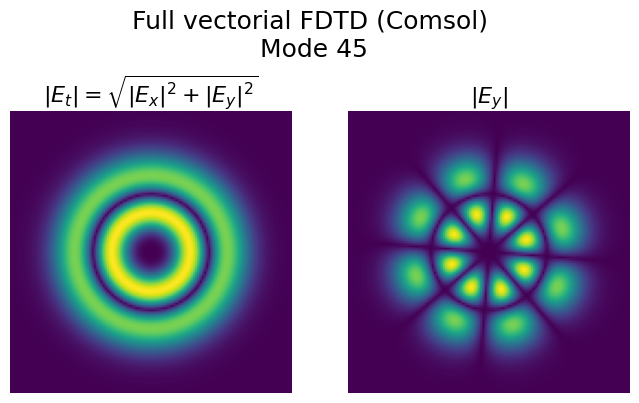

In [141]:
ind = 45

Ex = M0_cs[:npoints**2,ind].reshape([npoints]*2)
Ey = M0_cs[npoints**2:2*npoints**2,ind].reshape([npoints]*2)
Ez = M0_cs[2*npoints**2:,ind].reshape([npoints]*2)

max_E = np.max([np.max(np.abs(E)) for E in [Ex,Ey]])

plt.figure(figsize=[12,5])
plt.subplot(131)
plt.imshow(np.abs(Ex), vmax = max_E)
plt.axis('off')
plt.title(r'$|E_x|$')
plt.subplot(132)
plt.imshow(np.abs(Ey), vmax = max_E)
plt.axis('off')
plt.title(r'$|E_y|$')
plt.subplot(133)
plt.imshow(np.abs(Ez), vmax = max_E)
plt.axis('off')
plt.title(r'$|E_z|$')
plt.suptitle(f'Full vectorial FDTD (Comsol)\n Mode {ind}')

plt.figure(figsize=[8,5])
plt.subplot(121)
plt.imshow(np.sqrt(np.abs(Ex)**2+np.abs(Ey)**2), vmax = max_E)
plt.axis('off')
plt.title(r'$|E_t|=\sqrt{|E_x|^2+|E_y|^2}$')
plt.subplot(122)
plt.imshow(np.abs(Ey), vmax = max_E)
plt.axis('off')
plt.title(r'$|E_y|$')
plt.suptitle(f'Full vectorial FDTD (Comsol)\n Mode {ind}')

## 6. Compare propagation constants

### 6.1 Whole range

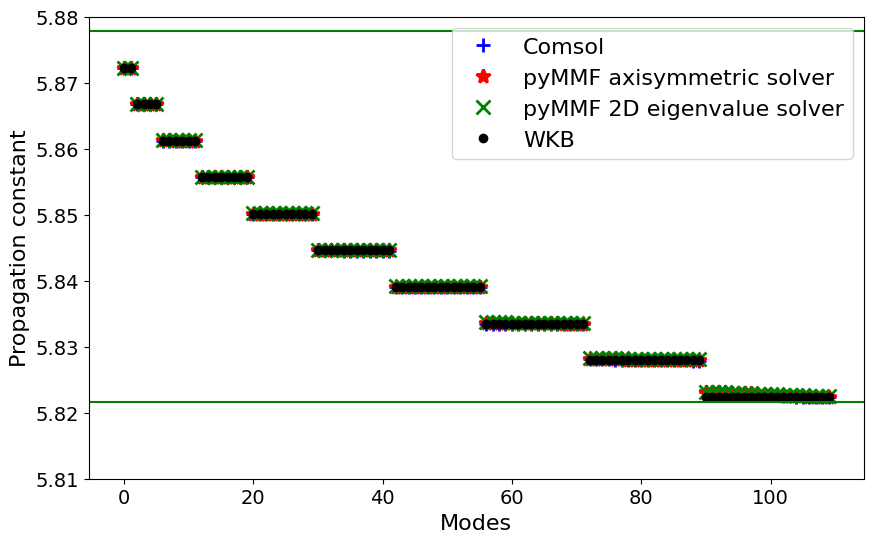

In [142]:
msize = 10
beta_max = k0*n1
beta_min = k0*np.min(profile.n)
plt.figure(figsize = (10,6))
plt.plot(np.abs(betas_cs[:110]),'b+', label = 'Comsol', markersize = msize, markeredgewidth=2)
plt.plot(betas_as,'r*', label = 'pyMMF axisymmetric solver', markersize = msize, markeredgewidth=2)
plt.plot(betas_eig,'gx', label = 'pyMMF 2D eigenvalue solver', markersize = msize, markeredgewidth=2)
plt.plot(betas_wkb,'k.', label = 'WKB', markersize = msize,markeredgewidth=2)
plt.axhline(beta_min, color='g')
plt.axhline(beta_max, color='g')
plt.xlabel('Modes')
plt.ylabel('Propagation constant')
plt.ylim([5.81,5.88])
plt.legend(fontsize=16, loc = 'upper right')

### 6.2 Zoom on lower order modes

Text(0.5, 1.0, 'Low order modes')

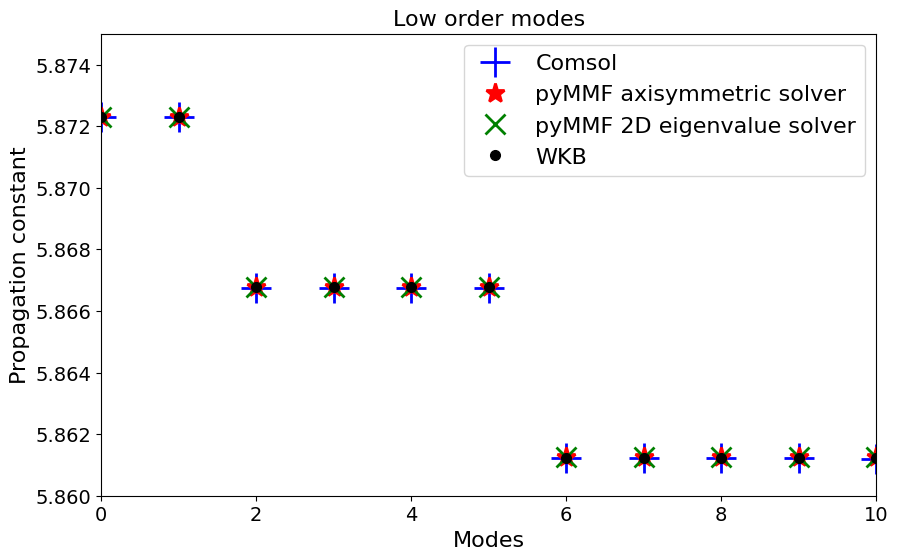

In [143]:
msize = 14
xlim = [0,10]
ylim = [5.86,5.875]
beta_max = k0*n1
beta_min = k0*np.min(profile.n)
plt.figure(figsize = (10,6))
plt.plot(np.abs(betas_cs[:110]),'b+', label = 'Comsol', markersize = 1.5*msize, markeredgewidth=2)
plt.plot(betas_as,'r*', label = 'pyMMF axisymmetric solver', markersize = msize, markeredgewidth=2)
plt.plot(betas_eig,'gx', label = 'pyMMF 2D eigenvalue solver', markersize = msize, markeredgewidth=2)
plt.plot(betas_wkb,'k.', label = 'WKB', markersize = msize,)
plt.axhline(beta_min, color='g')
plt.axhline(beta_max, color='g')
plt.xlabel('Modes')
plt.ylabel('Propagation constant')
plt.xlim(xlim)
plt.ylim(ylim)
plt.legend(fontsize=16, loc = 'upper right')
plt.title('Low order modes')

### 6.3 Zoom on higher order modes

Text(0.5, 1.0, 'High order modes')

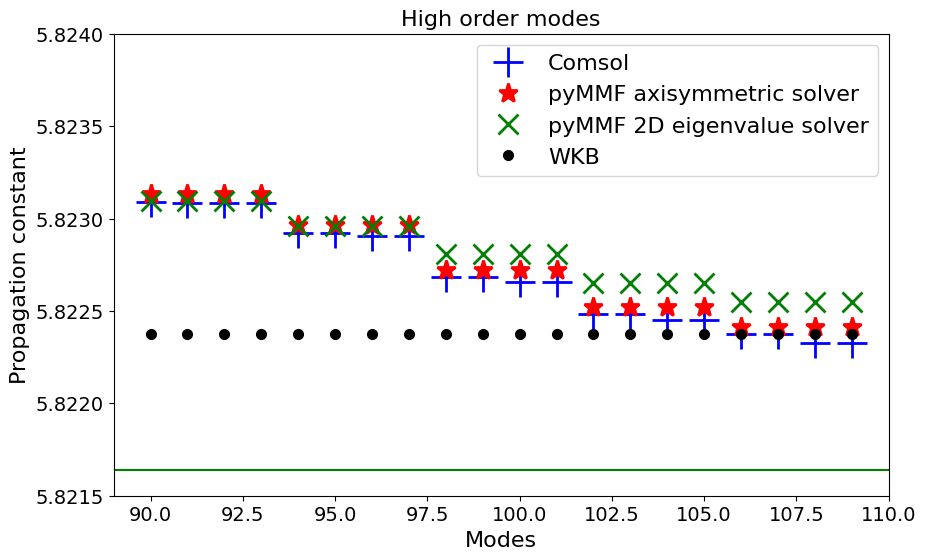

In [144]:
xlim = [89,110]
ylim = [5.8215,5.824]
beta_max = k0*n1
beta_min = k0*np.min(profile.n)
plt.figure(figsize = (10,6))
plt.plot(np.abs(betas_cs[:110]),'b+', label = 'Comsol', markersize = 1.5*msize, markeredgewidth=2)
plt.plot(betas_as,'r*', label = 'pyMMF axisymmetric solver', markersize = msize, markeredgewidth=2)
plt.plot(betas_eig,'gx', label = 'pyMMF 2D eigenvalue solver', markersize = msize, markeredgewidth=2)
plt.plot(betas_wkb,'k.', label = 'WKB', markersize = msize,)
plt.axhline(beta_min, color='g')
plt.axhline(beta_max, color='g')
plt.xlabel('Modes')
plt.ylabel('Propagation constant')
plt.xlim(xlim)
plt.ylim(ylim)
plt.legend(fontsize=16, loc = 'upper right')
plt.title('High order modes')

(-0.5, 127.5, 127.5, -0.5)

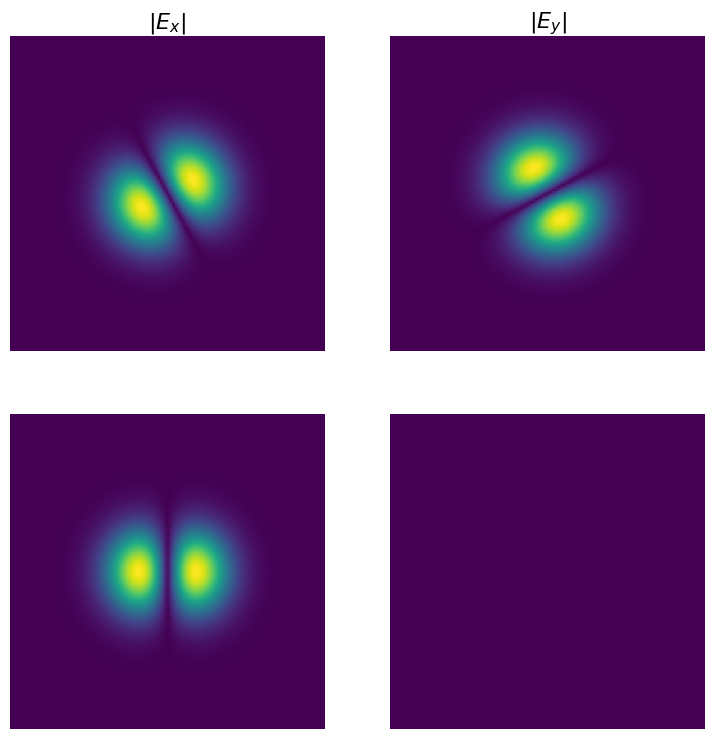

In [145]:
i = 4
ex = M0_cs[:npoints**2,i].reshape([npoints]*2)
ey = M0_cs[npoints**2:2*npoints**2,i].reshape([npoints]*2)
ex2 = M0_rad[:npoints**2,i].reshape([npoints]*2)
ey2 = M0_rad[npoints**2:,i].reshape([npoints]*2)

m = np.max([np.max(np.abs(ex)),np.max(np.abs(ey))])
m2 = np.max([np.max(np.abs(ex2)),np.max(np.abs(ey2))])
plt.figure(figsize=(9,9))
plt.subplot(221)
plt.imshow(np.abs(ex), vmax = m)
plt.axis('off')
plt.title(r'$|E_x|$')
plt.subplot(222)
plt.imshow(np.abs(ey), vmax = m)
plt.axis('off')
plt.title(r'$|E_y|$')
plt.subplot(223)
plt.imshow(np.abs(ex2), vmax = m2)
plt.axis('off')
plt.subplot(224)
plt.imshow(np.abs(ey2), vmax = m2)
plt.axis('off')

## 7. Projection of one basis onto the other one
#### The order **inside** each degenerate group is not exacty the same, but it is normal as they are (quasi) degenerate.

### First compute the mask corresponding to groups of degenerate modes

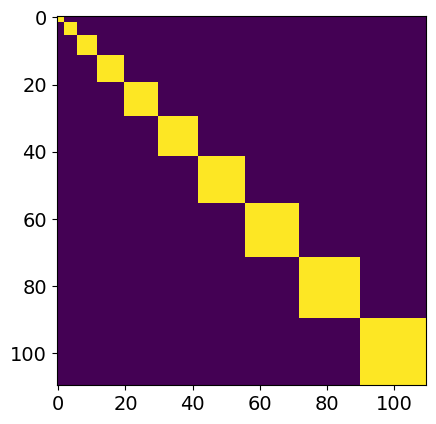

In [146]:
ind_degenerate = modes.getNearDegenerate(tol = 1e-3)
mask_degenerate = np.zeros(shape = [Nmodes*2]*2, dtype = float)

for ind in ind_degenerate:
    mask_degenerate[2*min(ind):2*max(ind)+2,2*min(ind):2*max(ind)+2] = 1

# mask_degenerate = np.kron(np.eye(2),mask_degenerate)  
plt.close('all')
plt.figure()
plt.imshow(mask_degenerate)

### 7.1 Display conversion matrices

We project the mode matrices obtained with the different solver onto the modes profiles from FDTD simulations.
Ideally, all energy is conserved and we have non-zero values only inside the degenerate block.
Note that this matrix is not purely diagonal as modes are degenerate inside each block.

In [147]:
# only keep transverse field and the propagating modes
M0_cs_trans = M0_cs[:2*npoints**2,:110]

A_as = M0_cs_trans.transpose().conjugate()@M0_rad
A_eig = M0_cs_trans.transpose().conjugate()@M0_eig
A_wkb = M0_cs_trans.transpose().conjugate()@M0_wkb

We define a loss term as the ratio energy of the conversion matrix that is out of the degenerate blocks.

Text(0.5, 1.0, 'WKB\n loss = 1.59e-03%')

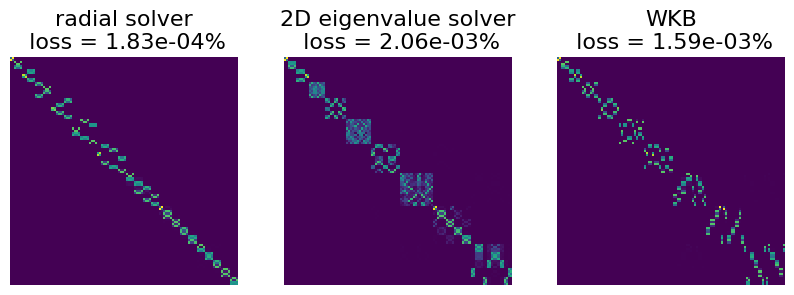

In [148]:
energy_loss_as = 1-np.linalg.norm(A_as*mask_degenerate)/np.linalg.norm(A_as)
energy_loss_eig = 1-np.linalg.norm(A_eig*mask_degenerate)/np.linalg.norm(A_eig)
energy_loss_wkb = 1-np.linalg.norm(A_wkb*mask_degenerate)/np.linalg.norm(A_wkb)

plt.figure(figsize = (10,4))
plt.subplot(131)
plt.imshow(np.abs(A_as), interpolation = 'None')
plt.axis('off')
plt.title(f'radial solver\n loss = {100*energy_loss_as:.2e}%')
plt.subplot(132)
plt.imshow(np.abs(A_eig), interpolation = 'None')
plt.axis('off')
plt.title(f'2D eigenvalue solver\n loss = {100*energy_loss_eig:.2e}%')
plt.subplot(133)
plt.imshow(np.abs(A_wkb), interpolation = 'None')
plt.axis('off')
plt.title(f'WKB\n loss = {100*energy_loss_wkb:.2e}%')


### 7.2 Conversion efficiency per mode

For each input mode found using the different technique, 
compute the energy that couples to the corresponding group of degenerate modes
found using Comsol.

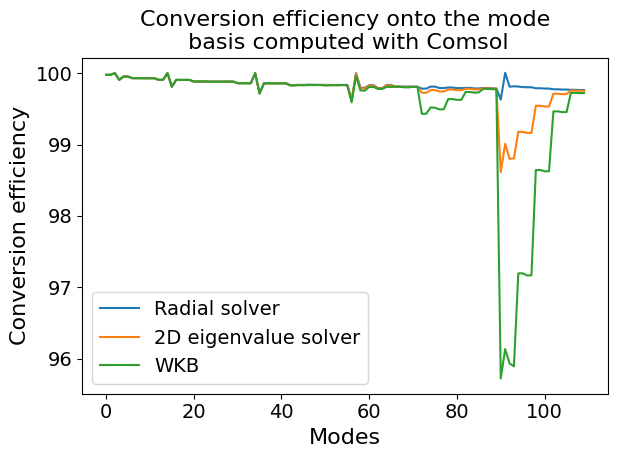

In [149]:
Proj_as = np.sqrt(np.sum( np.abs(A_as*mask_degenerate)**2, axis = 1))
Proj_eig = np.sqrt(np.sum( np.abs(A_eig*mask_degenerate)**2, axis = 1))
Proj_wkb = np.sqrt(np.sum( np.abs(A_wkb*mask_degenerate)**2, axis = 1))

plt.figure()
plt.plot(100*Proj_as, label = 'Radial solver')
plt.plot(100*Proj_eig, label = '2D eigenvalue solver')
plt.plot(100*Proj_wkb, label = 'WKB')
plt.ylabel('Conversion efficiency')
plt.xlabel('Modes')
plt.legend()
yticks = np.linspace(95,100,6)
# plt.yticks(yticks, [f'{y:g}%' for y in yticks])
plt.title('Conversion efficiency onto the mode\n basis computed with Comsol')
plt.tight_layout()

### 7.3 Global conversion losses

We compute the singular value decomposition of the conversion matrix between the modes found using Comsol
and using the pyMMF solvers $M_\text{cs}^\dagger . M_\text{pyMMF}$. 
Ideally, if two bases represent the same subspace, the conversion matrix has to be unitary, 
i.e. all its singular values are equal to one.

Text(0.5, 1.0, 'Singular values of conversion matrices')

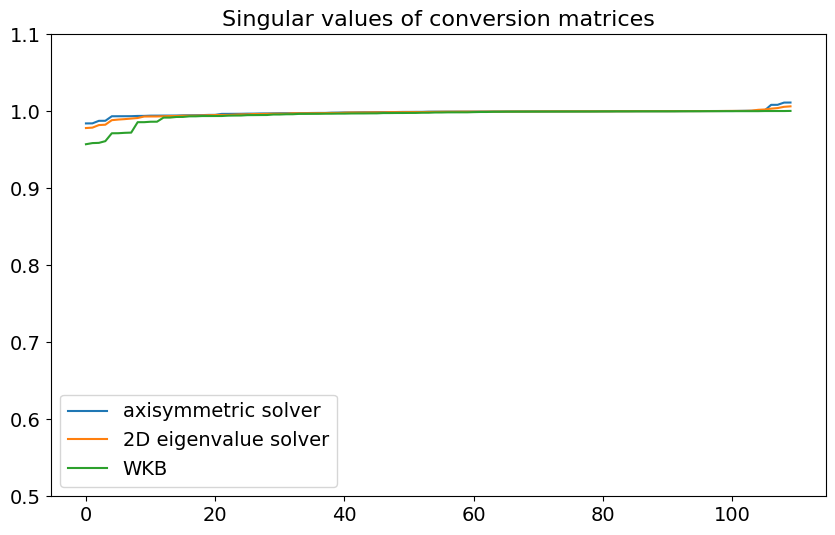

In [29]:
_,s_as,_ = np.linalg.svd(A_as)
_,s_eig,_ = np.linalg.svd(A_eig)
_,s_wkb,_ = np.linalg.svd(A_wkb)
plt.figure(figsize = (10,6))
plt.plot(np.sort(np.abs(s_as)), label = 'axisymmetric solver')
plt.plot(np.sort(np.abs(s_eig)), label = '2D eigenvalue solver')
plt.plot(np.sort(np.abs(s_wkb)), label = 'WKB')
plt.ylim([0.5, 1.1])
plt.legend()
plt.title('Singular values of conversion matrices')